# Training OffensiveCoordinatorRNN (Expert)
This notebook demonstrates the training of the RNN expert model for NFL play prediction. The RNN expert focuses on pre-snap temporal features of the offensive formation to predict whether a play will be a pass or run.

## Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
from experts.rnn import OffensiveCoordinatorRNN
from etl.dataloader import ExpertDataset

## Loading Dataset

See `etl` module for more details.

In [4]:
# Make test-train-split
from sklearn.model_selection import train_test_split


df = pd.read_csv('features/target.csv')

# Split into train (80%) and test (20%) sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [5]:
# create the dataset
RNN_train_dataset = ExpertDataset(df_train, expert_name="rnn")
RNN_val_dataset = ExpertDataset(df_test, expert_name="rnn")

In [6]:
# Get features and targets from dataset
X_train, y_train = RNN_train_dataset.features, RNN_train_dataset.targets
X_val, y_val = RNN_val_dataset.features, RNN_val_dataset.targets

In [7]:
X_train.shape, y_train.shape

((11143, 11, 10, 7), (11143,))

In [8]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Training expert
See `experts` module for more details. Specifically, see `experts/rnn.py` for more details.

**Architecture**
- Input: Player formation sequences (11 players × 7 features × 10 timesteps)
- 2-layer LSTM with dropout (hidden size: 128)
- FC layer (128→1)
- Output: binary classification (1 for pass, 0 for run)

In [9]:
rnn_model = OffensiveCoordinatorRNN()

In [10]:
num_epochs = 100
batch_size = 32

train_metrics = rnn_model.train(train_loader, val_loader, num_epochs, 0.001)

Epoch 1/100, Train Loss: 0.6713, Train Accuracy: 0.6085
	Validation Loss: 0.6680, Validation Accuracy: 0.6116
Epoch 2/100, Train Loss: 0.6705, Train Accuracy: 0.6085
	Validation Loss: 0.6679, Validation Accuracy: 0.6125
Epoch 3/100, Train Loss: 0.6695, Train Accuracy: 0.6095
	Validation Loss: 0.6700, Validation Accuracy: 0.6123
Epoch 4/100, Train Loss: 0.6672, Train Accuracy: 0.6088
	Validation Loss: 0.6708, Validation Accuracy: 0.6129
Epoch 5/100, Train Loss: 0.6611, Train Accuracy: 0.6091
	Validation Loss: 0.6761, Validation Accuracy: 0.6134
Epoch 6/100, Train Loss: 0.6524, Train Accuracy: 0.6088
	Validation Loss: 0.6794, Validation Accuracy: 0.6127
Epoch 7/100, Train Loss: 0.6328, Train Accuracy: 0.6088
	Validation Loss: 0.7089, Validation Accuracy: 0.6125
Epoch 8/100, Train Loss: 0.6018, Train Accuracy: 0.6088
	Validation Loss: 0.7011, Validation Accuracy: 0.6123
Epoch 9/100, Train Loss: 0.5611, Train Accuracy: 0.6095
	Validation Loss: 0.7854, Validation Accuracy: 0.6125
Epoch 10/1

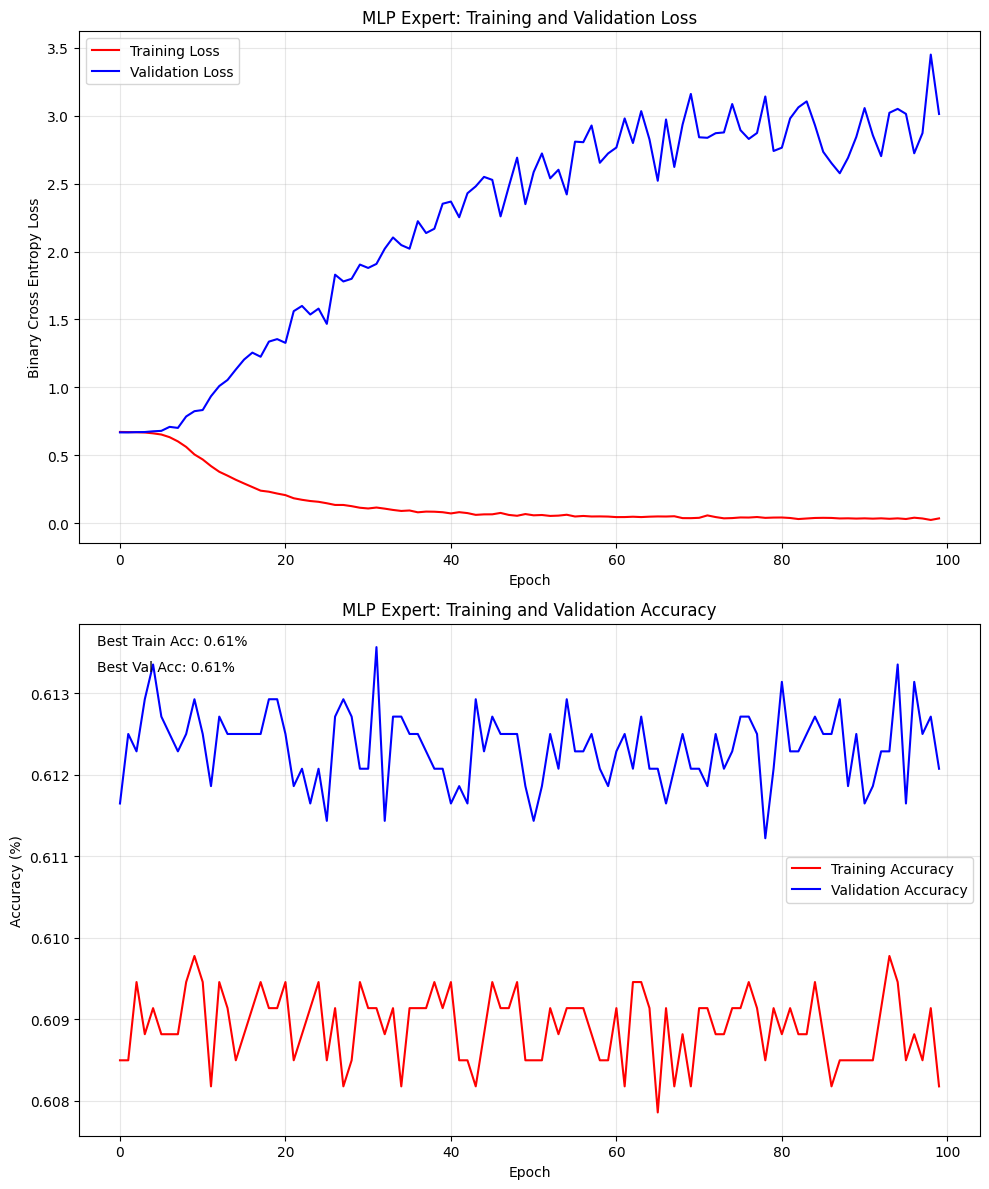

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
ax1.plot(train_metrics['train_losses'], label='Training Loss', color='red')
if train_metrics['val_losses']:
    ax1.plot(train_metrics['val_losses'], label='Validation Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross Entropy Loss')
ax1.set_title('MLP Expert: Training and Validation Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot accuracies
ax2.plot(train_metrics['train_accuracies'], label='Training Accuracy', color='red')
if train_metrics['val_accuracies']:
    ax2.plot(train_metrics['val_accuracies'], label='Validation Accuracy', color='blue')
    
# Add best accuracies as text
best_train_acc = max(train_metrics['train_accuracies'])
ax2.text(0.02, 0.98, f'Best Train Acc: {best_train_acc:.2f}%', 
         transform=ax2.transAxes, verticalalignment='top')
if train_metrics['val_accuracies']:
    best_val_acc = max(train_metrics['val_accuracies'])
    ax2.text(0.02, 0.93, f'Best Val Acc: {best_val_acc:.2f}%',
             transform=ax2.transAxes, verticalalignment='top')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MLP Expert: Training and Validation Accuracy')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()